## Point to Data

In [1]:
# If you are stating from scratch, the folder should have subfolders containing one full experiment,
# with the following CSVs from CRITTA:
# 1. FeedLog_..._.csv
# 2. FeedStats_..._.csv
datadir='/Users/josesho/bin/espresso/starvation-gradient'

## Load Libraries

In [2]:
import sys
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['mathtext.rm'] = 'Arial'
%matplotlib inline

import seaborn as sns
# # For annotating plots later.
# from string import ascii_uppercase as alphabet
# alphabet_labels=dict( zip(range(0,26), alphabet) )

# # import bokeh here and ipython widgets here.
# from ipywidgets import interact

# from bokeh.io import push_notebook, show, output_notebook, export_png, export_svgs
# from bokeh.layouts import column, row, gridplot
# from bokeh.models import Range1d
# from bokeh.plotting import figure
# output_notebook()

import bootstrap_contrast as bs
import plot_helpers as pthelp # custom functions.

os.chdir(datadir)

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Munge Data

In [6]:
# # Write allfeeds to file, as a checkpoint.
# allfeeds.to_csv('w1113_starvation_gradient_allfeeds.csv',index=False)
# allflies.to_csv('w1113_starvation_gradient_allflies.csv',index=False)

# # Load data if it exists.
allfeeds=pd.read_csv('w1113_starvation_gradient_allfeeds.csv',index_col=False)
allflies=pd.read_csv('w1113_starvation_gradient_allflies.csv',index_col=False)
# Convert `RelativeTime_s` to DateTime object.
allfeeds['RelativeTime_s']=pd.to_datetime(allfeeds['RelativeTime_s'])

In [5]:
subfolders=np.sort( [f[0] for f in os.walk(datadir)] )[1:] # drop the first output corresponding to hidden file(s).
# print(subfolders)

# folder='/Volumes/NRP-SOD//Espresso-Data/Data/w1118/Hungry/48-Hrs' # Use for testing. 
allflies=[]
allfeeds=[]
allmetadata=[]
non_feeding_flies=[]

for folder in subfolders:
    starved_time=folder.split('/')[-1]
    files=os.listdir(folder)
    feedlogs=np.sort( [csv for csv in files if csv.endswith('.csv') and csv.startswith('FeedLog')] )

    # check that each feedlog has a corresponding metadata CSV.
    for feedlog in feedlogs:
        expected_metadata=feedlog.replace('FeedLog','MetaData')
        if expected_metadata not in files:
            raise NameError('A MetaData file for '+feedlog+' cannot be found.\n'+\
                            'MetaData files should start with "MetaData_" and '+\
                            'have the same datetime info as the corresponding FeedLog. Please check.')
    # Prepare variables.
    feedlogs_list=list()
    metadata_list=list()
    fly_counter=0
    
    for j, feedlog in enumerate(feedlogs):
        ## Read in metadata.
        metadata=feedlog.replace('FeedLog','MetaData')
        metadata_csv=pd.read_csv( os.path.join(folder,metadata) )
        ## Check that the metadata has a nonzero number of rows.
        if len(metadata_csv)==0:
            raise ValueError(metadata+' has 0 rows. Please check!!!')
        if j>0:
            metadata_csv.ID=metadata_csv.ID+fly_counter
        metadata_csv['starved_time']=np.repeat(starved_time,len(metadata_csv))
        metadata_csv['FlyID']=metadata_csv.starved_time.str.cat(metadata_csv.ID.astype(str),sep='_Fly')
        ## Save the munged metadata.
        metadata_list.append(metadata_csv)
        ## Save the fly IDs.
        allflies.append(metadata_csv[['FlyID','starved_time']])
            
        ## Read in feedlog.
        feedlog_csv=pd.read_csv( os.path.join(folder,feedlog) )
        ## Check that the feedlog has a nonzero number of rows.
        if len(feedlog_csv)==0:
            raise ValueError(feedlog+' has 0 rows. Please check!!!')
        ## Drop the feed events where `AviFile` is "Null", as well as events that have a negative `RelativeTime-s`.
        feedlog_csv.drop(feedlog_csv[feedlog_csv.AviFile=='Null'].index, inplace=True)
        feedlog_csv.drop(feedlog_csv[feedlog_csv['RelativeTime-s']<0].index, inplace=True)
        ## You have to ADD 1 to match the feedlog FlyID with the corresponding FlyID in `metadata_csv`.
        ## Also, increment each FlyID by the total number of flies in previous feedlogs.
        feedlog_csv.FlyID=feedlog_csv.FlyID+1
        if j>0:
            feedlog_csv.FlyID=feedlog_csv.FlyID+fly_counter
        feedlog_csv.loc[:,'FlyID']=pd.Series(np.repeat(starved_time,
                                                       len(feedlog_csv))).str.cat(feedlog_csv.FlyID.astype(str),
                                                                                               sep='_Fly')
        ## Add current fly count to fly_counter.
        fly_counter+=len(metadata_csv)
        
        ## Define 2 padrows per fly, per food choice (in this case, only one),
        ## that will ensure feedlogs for each FlyID fully capture the entire 6-hour duration.
        for flyid in metadata_csv.FlyID.unique():
            ## Identify flies that did not have any feed events. Were these chambers empty? Or the flies dead?
            if flyid not in feedlog_csv.FlyID.unique():
                non_feeding_flies.append(flyid)
            for choice in feedlog_csv.ChoiceIdx.unique():
                padrows=pd.DataFrame( [ [np.nan,np.nan,choice,
                                         flyid,choice,'NIL',
                                         np.nan,np.nan,np.nan,
                                         False,0.5,'PAD', # 0.5 seconds
                                        ],
                                       [np.nan,np.nan,choice,
                                        flyid,choice,'NIL',
                                        np.nan,np.nan,np.nan,
                                        False,21891,'PAD', # 6 hrs, 5 min, 1 sec in seconds.
                                       ] ]
                                    )
                padrows.columns=feedlog_csv.columns
            # Add the padrows to `temp`.
            feedlog_csv=feedlog_csv.append(padrows,ignore_index=True) # there is no `inplace` argument for append.
        ## Save the munged feedlog.
        feedlogs_list.append(feedlog_csv)

    # Join all processed feedlogs and metadata into respective DataFrames.
    feedlogs_list=pd.concat(feedlogs_list).reset_index(drop=True)
    metadata_list=pd.concat(metadata_list).reset_index(drop=True)

    # merge metadata with feedlogs.
    merged=pd.merge(feedlogs_list,metadata_list,left_on='FlyID',right_on='FlyID')
    # rename columns and food types as is appropriate.
    merged.rename(columns={"Food 1":"Tube1", 
                           "Food 2":"Tube2",
                           'Volume-mm3':'FeedVol_µl',
                           'Duration-ms':'FeedDuration_ms',
                           'RelativeTime-s':'RelativeTime_s'},inplace=True)
    merged.loc[:,'Tube1']=merged.Tube1.str.replace('5%S','5% sucrose ').str.replace('5%YE',' 5% yeast extract')
    merged.loc[:,'Genotype']=merged.Genotype.str.replace('W','w')
    # Discard superfluous columns.
    merged.drop('ID',axis=1,inplace=True)
#     merged.drop_duplicates(inplace=True) # not entirely sure why I need to do this?
    # Drop anamalous feed events from Tube2 (aka ChoiceIdx=1), where there was no feed tube in the first place.
    feeds_to_drop_count=len(merged[merged.ChoiceIdx==1])
    print('A total of {0} feeds (out of {1}) from flies starved for {2} from the non-existent Tube2 will be dropped.'.format(feeds_to_drop_count,
                                                                                                                             len(merged),
                                                                                                                             starved_time) )
    merged.drop(merged[merged.ChoiceIdx==1].index,inplace=True)
    merged.reset_index(drop=True,inplace=True)
    allfeeds.append(merged)
    
# Concatenate lists from the above loop.
allflies=pd.concat(allflies)
allfeeds=pd.concat(allfeeds)

# Compute feed volume in nanoliters for convenience.
allfeeds['FeedVol_nl']=allfeeds['FeedVol_µl']*1000
# Compute feeding speed.
allfeeds['FeedSpeed_nl/s']=allfeeds['FeedVol_nl']/(allfeeds['FeedDuration_ms']/1000)
# Duplicate `RelativeTime_s` as non-DateTime object.
allfeeds['feed_time_s']=allfeeds['RelativeTime_s']
# Convert `RelativeTime_s` to DateTime object.
allfeeds['RelativeTime_s']=pd.to_datetime(allfeeds['RelativeTime_s'],unit='s')
allfeeds['feed_duration_s']=allfeeds.FeedDuration_ms/1000      
# Sort by FlyID, then by RelativeTime
allfeeds.sort_values(['FlyID','RelativeTime_s'],inplace=True)

# Reset the indexes.
for df in [allflies,allfeeds]:
    df.reset_index(drop=True,inplace=True)

# Record which flies did not feed.
allflies['fed_during_assay']=np.repeat('Yes',len(allflies))
allflies.set_index('FlyID',inplace=True,drop=True)
allflies.loc[non_feeding_flies,'fed_during_assay']='No'

allfeeds.to_csv('w1113_starvation_gradient_allfeeds.csv',index=False)
allflies.reset_index(inplace=True)
allflies.to_csv('w1113_starvation_gradient_allflies.csv',index=False)

A total of 0 feeds (out of 304) from flies starved for 0-Hrs from the non-existent Tube2 will be dropped.
A total of 0 feeds (out of 622) from flies starved for 12-Hrs from the non-existent Tube2 will be dropped.
A total of 3 feeds (out of 1193) from flies starved for 24-Hrs from the non-existent Tube2 will be dropped.
A total of 2 feeds (out of 1547) from flies starved for 48-Hrs from the non-existent Tube2 will be dropped.
A total of 0 feeds (out of 2183) from flies starved for 72-Hrs from the non-existent Tube2 will be dropped.


## Set palette and swarmplot arguments

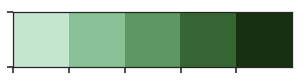

In [20]:
color_palette=(sns.cubehelix_palette(n_colors=len(allfeeds.starved_time.unique()),
                                     start=1.8, 
#                                      dark=0.8,
                                  rot=.1)
              )
color_palette_dict=dict(zip(allfeeds.starved_time.unique(),color_palette))

sns.set(style='ticks',context='poster')

sns.palplot(color_palette)
bs_kwargs=dict(fig_size=(12,9),
               float_contrast=False,
               custom_palette=color_palette,
               font_scale=1.4,
               color_col='starved_time',
               idx=np.sort(allflies.starved_time.unique()),
               swarmplot_kwargs={'size':6})

## Raster Plots and Time Course

In [9]:
# munging for timecourse data.
allfeeds_timecourse=pd.DataFrame ( 
                            allfeeds.groupby(['starved_time']).\
                            resample('10min',on='RelativeTime_s').\
                            sum().to_records() )
allfeeds_timecourse_fv=allfeeds_timecourse.loc[:,['starved_time','RelativeTime_s','FeedVol_µl']]
allfeeds_timecourse_fv.fillna(0,inplace=True)
allfeeds_timecourse_fv['feed_time_s']=allfeeds_timecourse_fv.RelativeTime_s.dt.hour*3600+\
                                        allfeeds_timecourse_fv.RelativeTime_s.dt.minute*60+\
                                        allfeeds_timecourse_fv.RelativeTime_s.dt.second

plotting 0-Hrs rasters
plotting 0-Hrs timecourse
plotting 12-Hrs rasters
plotting 12-Hrs timecourse
plotting 24-Hrs rasters
plotting 24-Hrs timecourse
plotting 48-Hrs rasters
plotting 48-Hrs timecourse
plotting 72-Hrs rasters
plotting 72-Hrs timecourse


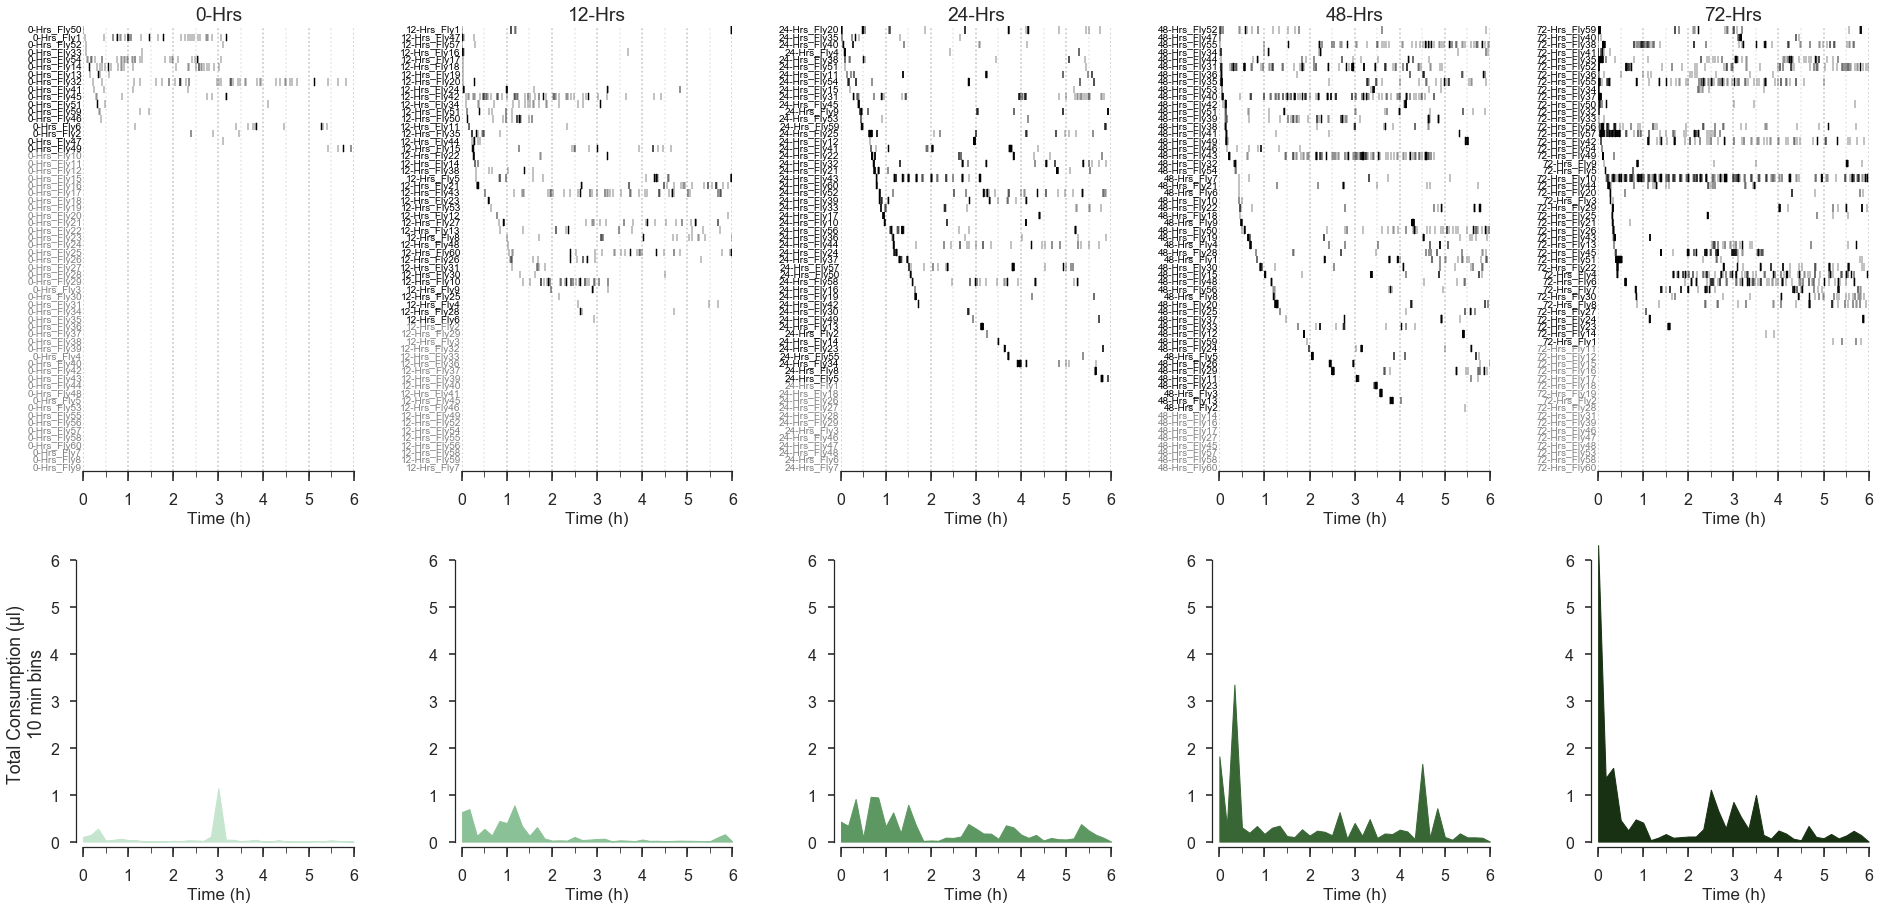

In [10]:
add_flyid_labels=True # Set to False if you don't want to show the flyids on the y-axis.

maxflycount=allflies.groupby('starved_time').count().FlyID.max()

sns.set(style='ticks',context='poster')
if add_flyid_labels:
    ws=0.4
else:
    ws=0.2
    
fig,axx=plt.subplots(nrows=2,
                     ncols=int(len(allfeeds.starved_time.unique())),
                     figsize=(32,15),
                     gridspec_kw={'wspace':ws,
                                  'hspace':0.2,
                                  'height_ratios':(3,2)} )

for c, time in enumerate(allfeeds.starved_time.unique()):

    print('plotting {0} {1}'.format(time,'rasters'))
    # Plot the raster plots.
    rasterax=axx[0,c]
    rasterax.xaxis.grid(True,linestyle='dotted',which='major',alpha=1)
    rasterax.xaxis.grid(True,linestyle='dotted',which='minor',alpha=0.5)
    
    # Grab only the flies we need.
    tempfeeds=allfeeds[allfeeds.starved_time==time]
    temp_allflies=tempfeeds.FlyID.unique().tolist()

    # Grab the columns we need.
    tempfeeds=tempfeeds[['FlyID','starved_time','feed_time_s','feed_duration_s']]#.dropna()

    # Order the flies properly.
    ## First, drop non-valid feeds, then sort by feed time and feed duration,
    ## then pull out FlyIDs in that order.
    temp_feeding_flies=tempfeeds[~np.isnan(tempfeeds.feed_duration_s)].\
                            sort_values(['feed_time_s','feed_duration_s']).FlyID.\
                            drop_duplicates().tolist()
    ## Next, identify which flies did not feed (aka not in list above.)
    temp_non_feeding_flies=[fly for fly in temp_allflies if fly not in temp_feeding_flies]
    ## Now, join these two lists.
    flies_in_order=temp_feeding_flies+temp_non_feeding_flies
    
    flycount=int(len(flies_in_order))
    for k, flyid in enumerate(flies_in_order):
        tt=tempfeeds[tempfeeds.FlyID==flyid]
        for idx in [idx for idx in tt.index if ~np.isnan(tt.loc[idx,'feed_duration_s'])]:
            rasterax.axvspan(xmin=tt.loc[idx,'feed_time_s'], 
                             xmax=tt.loc[idx,'feed_time_s']+tt.loc[idx,'feed_duration_s'],
                             ymin=(1/maxflycount)*(maxflycount-k-1),
                             ymax=(1/maxflycount)*(maxflycount-k),
                             color='k', 
                             alpha=1)
        if add_flyid_labels:
            if flyid in temp_non_feeding_flies:
                label_color='grey'
            else:
                label_color='black'
            rasterax.text(-85, (1/maxflycount)*(maxflycount-k-1) + (1/maxflycount)*.5, 
                        flyid,
                        color=label_color,
                        verticalalignment='center',
                        horizontalalignment='right',
                        fontsize=10)
    rasterax.yaxis.set_visible(False)
    rasterax.set_title(time)

    # Plot the time course feed volume plots.
    print('plotting {0} {1}'.format(time,'timecourse'))
    timecourseax=axx[1,c]
    temp_df=allfeeds_timecourse_fv[allfeeds_timecourse_fv.starved_time==time]
    timecourseax.fill_between(x=temp_df['feed_time_s'],
                              y1=temp_df['FeedVol_µl'],
                              y2=np.repeat(0,len(temp_df)),
                              color=color_palette_dict[time],lw=1)
    timecourseax.set_ylim(0,allfeeds_timecourse_fv['FeedVol_µl'].max())
    if c==0:
        timecourseax.set_ylabel('Total Consumption (µl)\n10 min bins')
        
    # Format x-axis for both axes.
    for a in [rasterax, timecourseax]:
        a.set_xlim(0,21600)
        a.xaxis.set_ticks(range(0,25200,3600))
        a.xaxis.set_minor_locator( tk.MultipleLocator(base=1800) )
        a.set_xlabel('Time (h)',fontsize=17)
        newlabels=[str(int(t/3600)) for t in a.xaxis.get_ticklocs(minor=False)]
        a.set_xticklabels(newlabels)
        a.tick_params(axis='x', which='major',length=10)
        a.tick_params(axis='x', which='minor',length=6)
        
    sns.despine(ax=rasterax,left=True,trim=True)
    sns.despine(ax=timecourseax,trim=True,offset={'left':7,'bottom':5})

## Cumulative feeding

In [11]:
### CUMULATIVE FEEDING
allfeeds['ValidCount']=allfeeds.Valid.astype(int) # Add column to catch cumulative feed count.

# create ResampledDF
allfeeds_resamp=allfeeds.groupby(['starved_time','FlyID']).resample('1min',on='RelativeTime_s')

allfeeds_resamp_cumsum=pd.DataFrame(allfeeds_resamp\
                                        .sum()\
                                        .groupby(['starved_time','FlyID'])\
                                        .cumsum()\
                                        .groupby(['starved_time','FlyID'])\
                                        .fillna(method='pad')\
                                        .fillna(0)\
                                        .to_records() )[['FlyID','starved_time','RelativeTime_s',
                                                         'FeedVol_nl','ValidCount']]

# Add time column (in minutes) to facilitate plotting.
for df in [#allfeeds_resamp_cumsum_count,
           allfeeds_resamp_cumsum]:
    df['RelativeTime_min']=df.RelativeTime_s.dt.hour*60 + df.RelativeTime_s.dt.minute
    
allfeeds_resamp_cumsum.rename( columns={'FeedVol_nl':'Cumulative Volume (nl)',
                                        'ValidCount':'Cumulative Feed Count',
                                       'starved_time':'Time Starved'},
                             inplace=True)

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


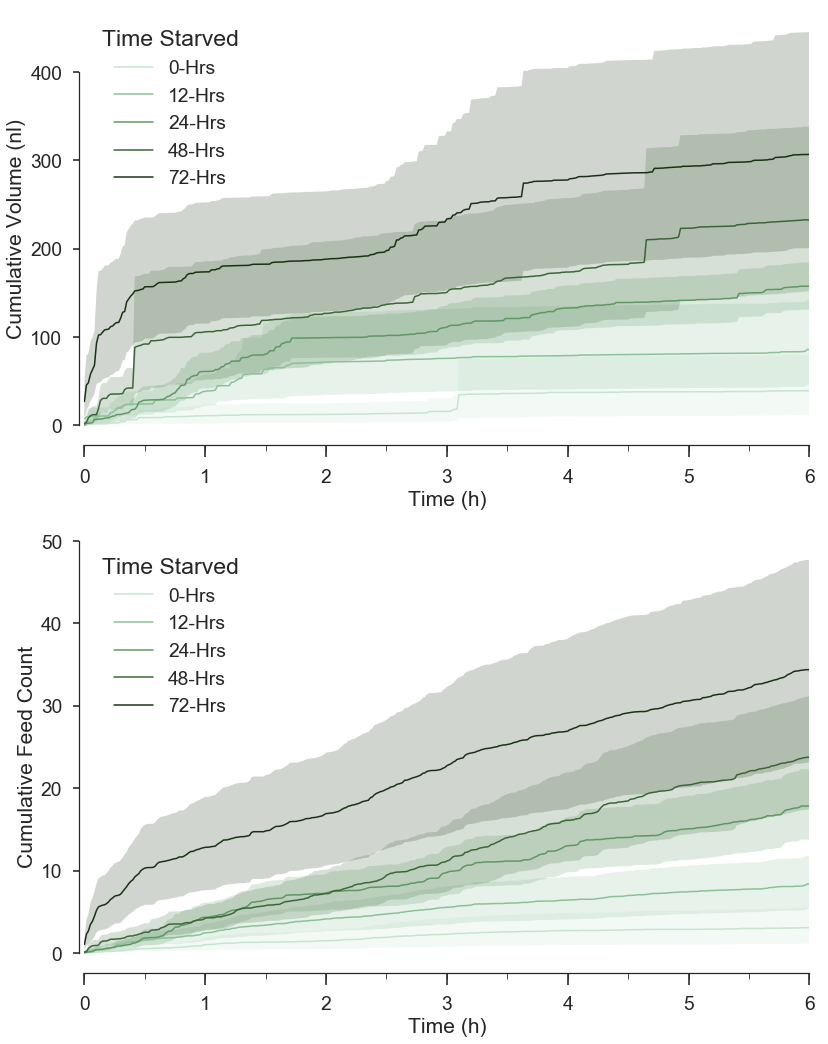

In [12]:
sns.set(style='ticks',context='poster',font_scale=1.2)

tsplot_kwargs=dict(time='RelativeTime_min',
                   unit='FlyID',
                   condition='Time Starved',
                   ci=95,
                   color=color_palette,
                   linewidth=1.5)

f,axx=plt.subplots(ncols=1,nrows=2, 
                   figsize=(12,15),sharex=True)
             
sns.tsplot(data=allfeeds_resamp_cumsum,
           value='Cumulative Volume (nl)',
           ax=axx[0],
           **tsplot_kwargs)
sns.tsplot(data=allfeeds_resamp_cumsum,
           value='Cumulative Feed Count',
           ax=axx[1],
           **tsplot_kwargs)

for ax in axx:
    ax.xaxis.set_major_locator(tk.MultipleLocator(base=60))
    ax.xaxis.set_minor_locator(tk.MultipleLocator(base=30))
    ax.set_xlim(0,360)
    ax.xaxis.set_ticklabels(range(0,7))
    ax.set_xlabel('Time (h)')
    
    ax.tick_params(axis='x', which='major',length=12)
    ax.tick_params(axis='x', which='minor',length=6)
    
    sns.despine(ax=ax, trim=True, offset={'left':5})
    
f.tight_layout()

## Percent Feeding

In [13]:
# Get plotting variables.
percent_feeding_summary=pthelp.compute_percent_feeding(allflies,allfeeds,'starved_time',end=360)
xindex=percent_feeding_summary.index.tolist()
cilow=percent_feeding_summary.ci_lower.tolist()
cihigh=percent_feeding_summary.ci_upper.tolist()
ydata=percent_feeding_summary.percent_feeding.tolist()

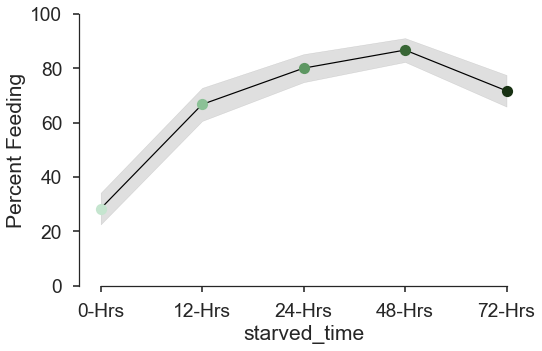

In [16]:
f,ax=plt.subplots(1,figsize=(8,5))
ax.set_ylim(0,100)
ax.fill_between(range(0,len(percent_feeding_summary)),
                cilow,cihigh,
                alpha=0.25,
                color='grey'
               )
percent_feeding_summary.percent_feeding.plot.line(ax=ax,color='k',lw=1.2)
for j,s in enumerate(ydata):
    ax.plot(j, s, 'o',
            color=color_palette[j])
ax.set_xlim(-0.2,4.2)
sns.despine(ax=ax,trim=True,offset={'left':1})
ax.set_xticklabels(xindex)
ax.set_ylabel('Percent Feeding')

## Latency to First Feed and Total Ingestion

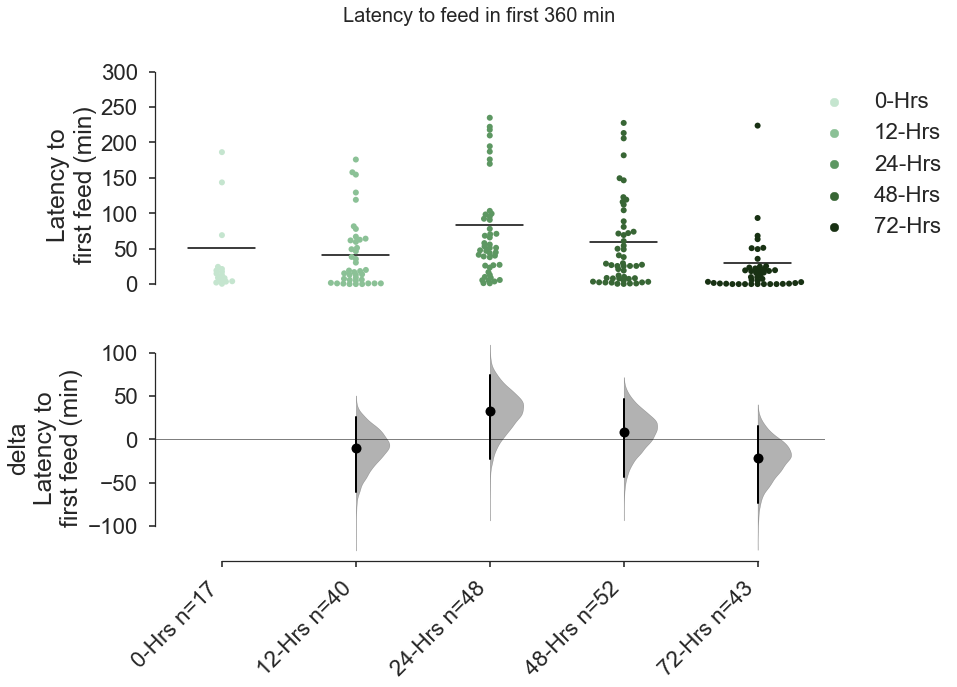

  reference_group experimental_group  stat_summary  bca_ci_low  bca_ci_high  \
0           0-Hrs             12-Hrs    -10.263416  -60.978846    25.670126   
1           0-Hrs             24-Hrs     32.617207  -22.330696    73.978110   
2           0-Hrs             48-Hrs      8.861820  -43.862050    46.909836   
3           0-Hrs             72-Hrs    -21.880495  -74.115408    15.200008   

     ci  is_difference  is_paired pvalue_1samp_ttest  pvalue_2samp_ind_ttest  \
0  95.0           True      False                NIL                0.572565   
1  95.0           True      False                NIL                0.183882   
2  95.0           True      False                NIL                0.676712   
3  95.0           True      False                NIL                0.265351   

  pvalue_2samp_paired_ttest  pvalue_mannWhitney pvalue_wilcoxon  
0                       NIL            0.895914             NIL  
1                       NIL            0.010027             NIL  
2    

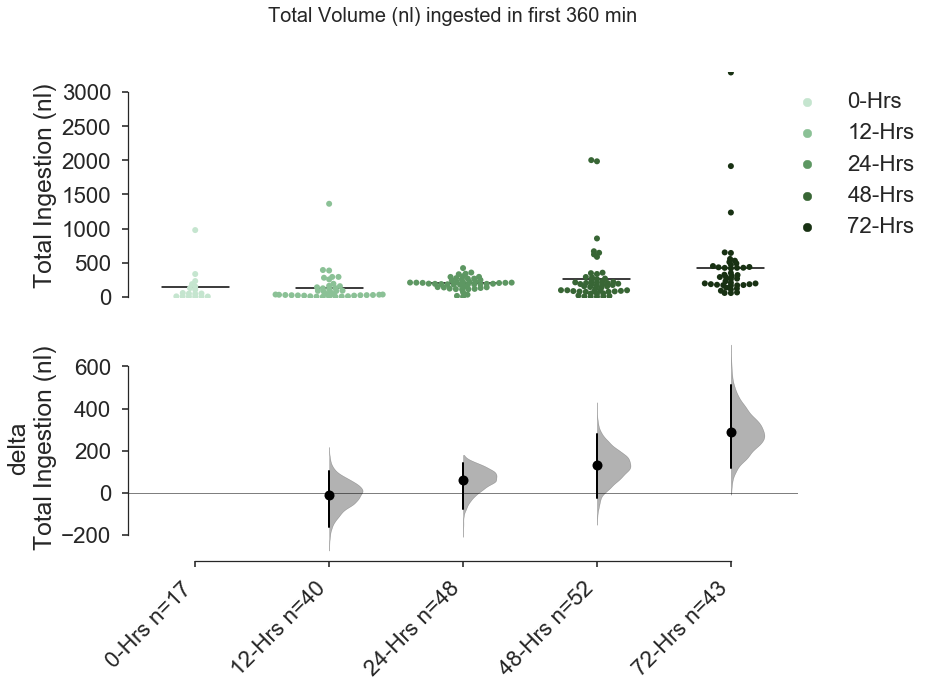

  reference_group experimental_group  stat_summary  bca_ci_low  bca_ci_high  \
0           0-Hrs             12-Hrs     -9.292119 -161.815701   102.808690   
1           0-Hrs             24-Hrs     58.869456  -79.684901   143.073923   
2           0-Hrs             48-Hrs    130.588225  -27.709812   278.289160   
3           0-Hrs             72-Hrs    290.117706  114.909598   510.631287   

     ci  is_difference  is_paired pvalue_1samp_ttest  pvalue_2samp_ind_ttest  \
0  95.0           True      False                NIL                0.889641   
1  95.0           True      False                NIL                0.141030   
2  95.0           True      False                NIL                0.201927   
3  95.0           True      False                NIL                0.041301   

  pvalue_2samp_paired_ttest  pvalue_mannWhitney pvalue_wilcoxon  
0                       NIL            0.854679             NIL  
1                       NIL            0.001296             NIL  
2    

In [28]:
# interact(latency_ingestion_plots, first_x_min=(1,360))
pthelp.latency_ingestion_plots(allfeeds,first_x_min=360)

## Feed Count Per fly

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_1samp_ttest,pvalue_2samp_ind_ttest,pvalue_2samp_paired_ttest,pvalue_mannWhitney,pvalue_wilcoxon
0,0-Hrs,12-Hrs,5.300000,1.500000,9.300000,95.0,True,False,NIL,8.703581e-03,NIL,3.316088e-05,NIL
1,0-Hrs,24-Hrs,14.766667,10.000000,19.633333,95.0,True,False,NIL,2.297011e-08,NIL,5.596254e-10,NIL
2,0-Hrs,48-Hrs,20.683333,14.300000,28.816667,95.0,True,False,NIL,1.147717e-07,NIL,5.600535e-12,NIL
3,0-Hrs,72-Hrs,31.316667,20.183333,45.650000,95.0,True,False,NIL,4.593424e-06,NIL,2.392984e-08,NIL


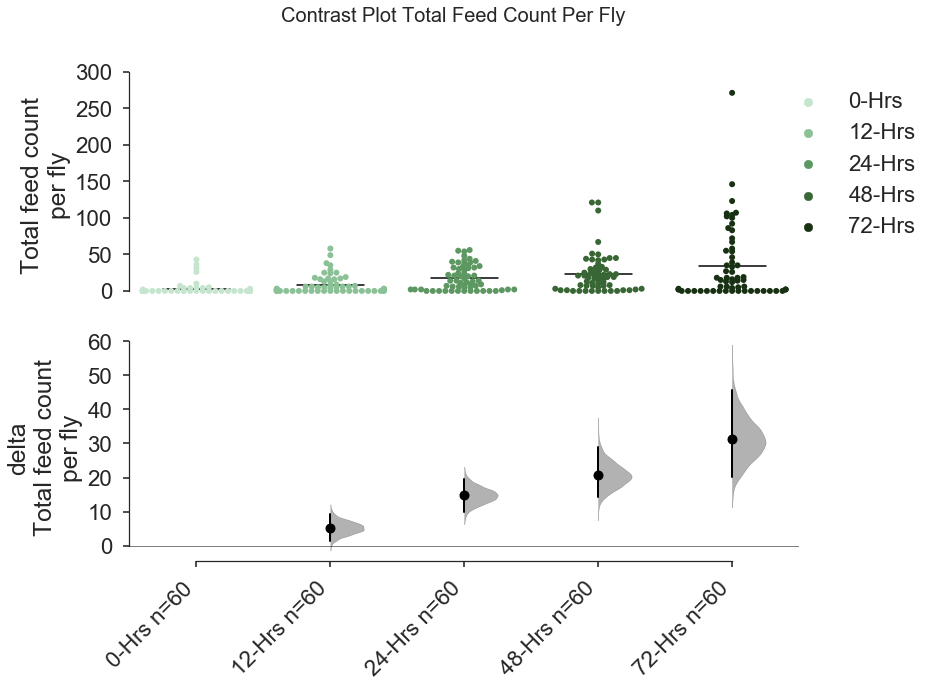

In [21]:
total_feeds=pd.DataFrame(allfeeds[['FlyID','starved_time','FeedVol_nl']].\
                          groupby(['starved_time','FlyID']).count().\
                          to_records())
total_feeds.columns=['starved_time','FlyID','Total feed count\nper fly']
max_feeds=np.round(total_feeds.max()['Total feed count\nper fly'],decimals=-2)

f3,b3=bs.contrastplot(data=total_feeds,
                      x='starved_time',y='Total feed count\nper fly',
                      swarm_ylim=(-10,max_feeds),
                      **bs_kwargs
                       )
f3.suptitle('Contrast Plot Total Feed Count Per Fly',fontsize=20)
b3

## Total Feed Volume Per Fly

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_1samp_ttest,pvalue_2samp_ind_ttest,pvalue_2samp_paired_ttest,pvalue_mannWhitney,pvalue_wilcoxon
0,0-Hrs,12-Hrs,-0.009292,-0.161994,0.104695,95.0,True,False,NIL,0.889641,NIL,0.854679,NIL
1,0-Hrs,24-Hrs,0.058869,-0.094447,0.141753,95.0,True,False,NIL,0.141030,NIL,0.001296,NIL
2,0-Hrs,48-Hrs,0.130588,-0.028538,0.275120,95.0,True,False,NIL,0.201927,NIL,0.016298,NIL
3,0-Hrs,72-Hrs,0.290118,0.111872,0.507450,95.0,True,False,NIL,0.041301,NIL,0.000041,NIL


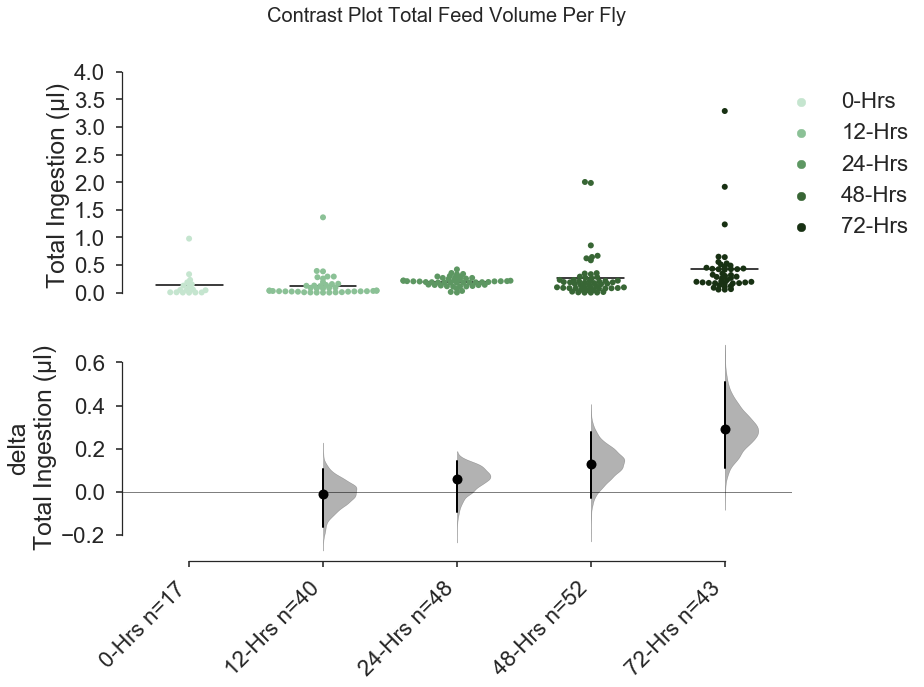

In [22]:
total_vol=pd.DataFrame(allfeeds[['FlyID','starved_time','FeedVol_µl']].\
                       groupby(['starved_time','FlyID']).sum().\
                       to_records())
total_vol.columns=['starved_time','FlyID','Total Ingestion (µl)']
max_vol=np.ceil(total_vol.max()['Total Ingestion (µl)'])
f4,b4=bs.contrastplot(data=total_vol,x='starved_time',y='Total Ingestion (µl)',
                      swarm_ylim=(-0.1,max_vol),
                      **bs_kwargs
                     )
f4.suptitle('Contrast Plot Total Feed Volume Per Fly',fontsize=20)
b4

## Feed Speed Per Fly

,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_1samp_ttest,pvalue_2samp_ind_ttest,pvalue_2samp_paired_ttest,pvalue_mannWhitney,pvalue_wilcoxon
0,0-Hrs,12-Hrs,0.697197,-14.856414,12.831762,95.0,True,False,NIL,0.928017,NIL,0.479913,NIL
1,0-Hrs,24-Hrs,-2.988063,-16.435657,5.299391,95.0,True,False,NIL,0.521996,NIL,0.145562,NIL
2,0-Hrs,48-Hrs,-3.941807,-19.693117,2.962470,95.0,True,False,NIL,0.280738,NIL,0.431399,NIL
3,0-Hrs,72-Hrs,-1.567258,-15.140620,6.212053,95.0,True,False,NIL,0.721534,NIL,0.049004,NIL


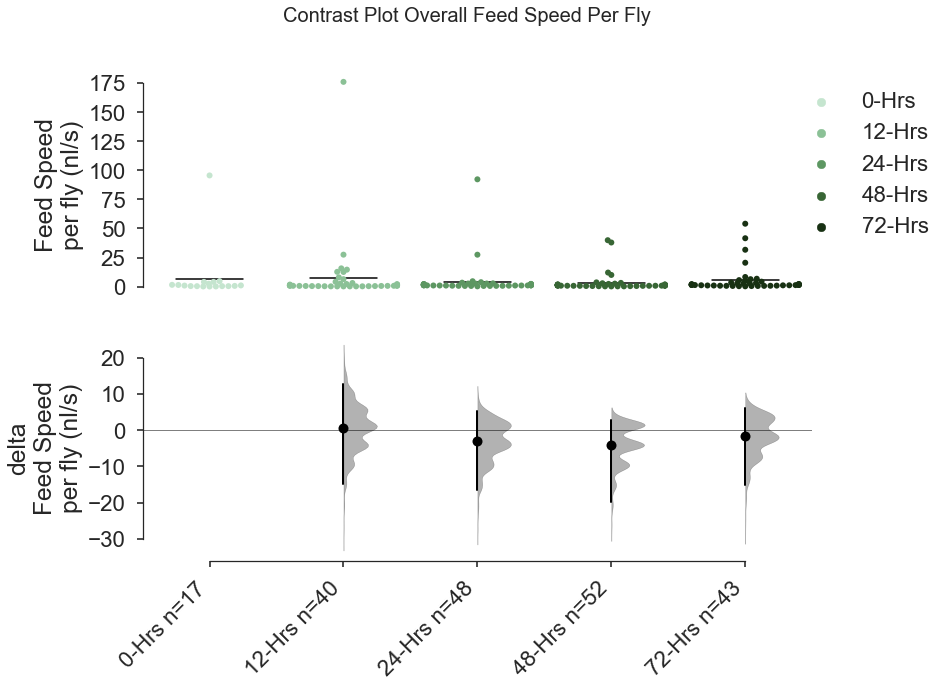

In [23]:
total_feed_vol_time_by_fly=pd.DataFrame(allfeeds[['starved_time','FlyID',
                                                  'FeedVol_nl','feed_duration_s']].\
                                        groupby(['starved_time','FlyID']).\
                                        sum().\
                                        to_records()
                                       )
total_feed_vol_time_by_fly['Feed Speed\nper fly (nl/s)']=total_feed_vol_time_by_fly.FeedVol_nl/total_feed_vol_time_by_fly.feed_duration_s

max_speed=total_feed_vol_time_by_fly.max()['Feed Speed\nper fly (nl/s)']*1.05
f5,b5=bs.contrastplot(data=total_feed_vol_time_by_fly,
                      x='starved_time',y='Feed Speed\nper fly (nl/s)',
                      swarm_ylim=(-10,max_speed),
                      stat_func=np.mean,
                      **bs_kwargs
                     )
f5.suptitle('Contrast Plot Overall Feed Speed Per Fly',fontsize=20)
b5

## Feed-wise analysis?

In [24]:
boxplot_args=dict(palette=color_palette,
                  showmeans=True,
                  meanline=True,
                  showfliers=False,
                  width=0.3,
                  meanprops=dict(linewidth=2,color='k',linestyle=':'),
                  medianprops=dict(linewidth=2,),
                  boxprops=dict(linewidth=0,alpha=0.65),
                  capprops=dict(alpha=0),
                  whiskerprops=dict(linewidth=1.5),
                  flierprops=dict(markersize=4,markerfacecolor='grey',
                                  alpha=0.5,marker='o')
                 )

axes_divider_args=dict(position="bottom", 
                 size="100%", 
                 pad=0.1)

violinplot_args=dict(showextrema=False, showmeans=False, widths=0.3)

total_feed_counts_by_starved_time=pd.DataFrame(allfeeds[['starved_time','FlyID','FeedVol_µl']].\
                                               groupby(['starved_time','FlyID']).\
                                               count().to_records()).groupby('starved_time').sum()
total_feed_counts_by_starved_time.columns=['total_feed_count']
total_feed_counts_by_starved_time['ticks']=total_feed_counts_by_starved_time.index.str.cat(' n='+total_feed_counts_by_starved_time.total_feed_count.astype(str))
# total_feed_counts_by_starved_time.plot.bar()

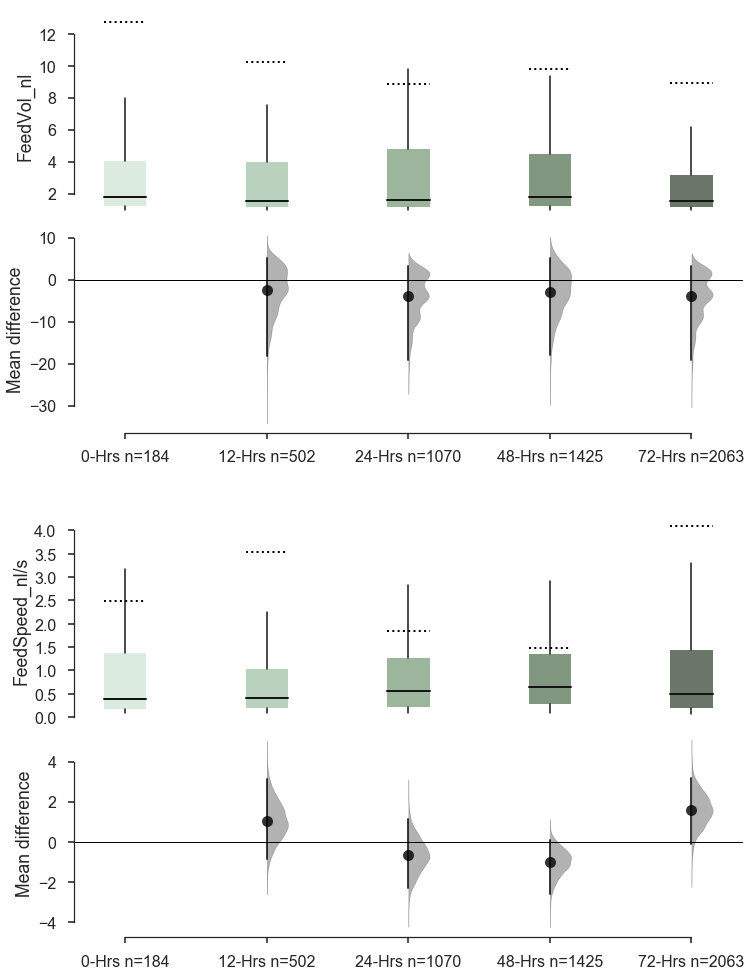

In [25]:
# If you want the mean, enter `np.mean`.
# If you want the median difference, enter `np.median`
statfun=np.mean 

## Initialise figure.
sns.set(style='ticks',context='poster')

f,ax_arr=plt.subplots(nrows=2,
                      ncols=1,
                      figsize=(12,17),
                      gridspec_kw=dict(wspace=0.2, # width-wise spacing.
                                       hspace=0.2) # height-wise spacing.
                     )

 ## Name axes for easy referencing.
boxplot_feed_vol=ax_arr[0]
boxplot_feed_rate=ax_arr[1]

df=allfeeds.copy()

if statfun==np.mean:
    ylab='Mean difference'
elif statfun==np.median:
    ylab='Median difference'
    
## Boxplot Feed Volume.
sns.boxplot(data=df,
            x='starved_time',y='FeedVol_nl',
            ax=boxplot_feed_vol,
            **boxplot_args                   
           )

## Contrast Plot Feed Volume
divider=make_axes_locatable(boxplot_feed_vol)
contrast_feed_vol=divider.append_axes(sharex=boxplot_feed_vol,**axes_divider_args)
for j,time in enumerate(df.starved_time.unique()[1:]):
    fv_boots=bs.bootstrap(x1=allfeeds[df.starved_time=='0-Hrs'].FeedVol_nl.dropna(),
                          x2=allfeeds[df.starved_time==time].FeedVol_nl.dropna(),
                         statfunction=statfun)
    # Plot half-violin boostraps.
    v=contrast_feed_vol.violinplot(fv_boots.stat_array, [j+1], **violinplot_args)
    bs.halfviolin(v)
    # Plot mean and ci.
    pthelp.meanci(fv_boots.summary, fv_boots.bca_ci_low, fv_boots.bca_ci_high, j+1, 
                  ax=contrast_feed_vol, size=11, lw=1.9)
    
 ## Boxplot Feed Rate
sns.boxplot(data=df,
            x='starved_time',y='FeedSpeed_nl/s',
            ax=boxplot_feed_rate,**boxplot_args
           )

## Contrast Plot Feed Volume
divider=make_axes_locatable(boxplot_feed_rate)
contrast_feed_rate=divider.append_axes(sharex=boxplot_feed_rate,**axes_divider_args)
for j,time in enumerate(df.starved_time.unique()[1:]):
    fr_boots=bs.bootstrap(x1=allfeeds[df.starved_time=='0-Hrs']['FeedSpeed_nl/s'].dropna(),
                          x2=allfeeds[df.starved_time==time]['FeedSpeed_nl/s'].dropna(),
                         statfunction=statfun)
    # Plot half-violin boostraps.
    v=contrast_feed_rate.violinplot(fr_boots.stat_array, [j+1], **violinplot_args)
    bs.halfviolin(v)
    # Plot mean and ci.
    pthelp.meanci(fr_boots.summary, fr_boots.bca_ci_low, fr_boots.bca_ci_high, j+1, 
                  ax=contrast_feed_rate, size=11, lw=1.9)

for ax in [boxplot_feed_vol,boxplot_feed_rate]:
    sns.despine(ax=ax, bottom=True, trim=True)
    ax.xaxis.set_visible(False)

for ax in [contrast_feed_vol,contrast_feed_rate]:
    ax.axhline(y=0,linewidth=1,color='k')
    ax.set_ylabel(ylab)
    ax.set_xticklabels(total_feed_counts_by_starved_time.ticks.tolist())
    sns.despine(ax=ax, trim=True)
    
# for a in f.axes:
#     sns.despine(ax=a, trim=True)

## Size of First Feed (not very informative?)

In [ ]:
# allfeeds_timewin=allfeeds[allfeeds.feed_time_s<60*60]

# first_feed_size=pd.DataFrame(allfeeds_timewin[['FlyID','starved_time','feed_time_s','FeedVol_nl']].\
#                              dropna().\
#                              groupby(['starved_time','FlyID']).\
#                              apply(np.min).\
#                              drop(['FlyID','starved_time','feed_time_s'],axis=1).\
#                              to_records())

# fx,bx=bs.contrastplot(data=first_feed_size,x='starved_time',y='FeedVol_nl',
#                         color_col='starved_time',
#                         float_contrast=False,
#                         custom_palette=color_palette,
#                         font_scale=1.2,
#                         idx=first_feed_size.starved_time.unique(),
#                         swarmplot_kwargs={'size':6}
#                        )
# bx